# 데이터셋 및 라이브러리 불러오기

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hypermodel import HyperModel

In [5]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import random

In [1]:
import os
import shutil

base_path = "./../../data/processed/02_kaggle_dataset"
new_base = os.path.join(base_path, "train")

os.makedirs(os.path.join(new_base, "closed"), exist_ok=True)
os.makedirs(os.path.join(new_base, "open"), exist_ok=True)

# 기존 폴더에서 새 폴더로 복사
# shutil.move(os.path.join(base_path, "closed_eye"), os.path.join(new_base, "closed"))
# shutil.move(os.path.join(base_path, "open_eye"), os.path.join(new_base, "open"))

# 모델 구축

In [7]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=86
BATCH_SIZE=16
SEED=42

datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    directory=new_base,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",  # 흑백 이미지
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    directory=new_base,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [9]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# model=Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
#     MaxPooling2D(2,2),
#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(2,2),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model = Sequential()

# Conv Block 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(2, 2))

# Conv Block 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Conv Block 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# FC Layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))  # 이진 분류

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\dear1\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping: val_loss가 patience만큼 개선되지 않으면 멈춤
esc=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# ModelCheckpoint: val_loss가 가장 낮은 시점마다 모델 저장
model_checkpoint=ModelCheckpoint("./../../src/models/02_Basic_Model/drowsiness_model.keras",
                                 monitor="val_loss", save_best_only=True, save_weights_only=False,
                                 mode='min', verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=1,
    callbacks=[esc, model_checkpoint]
)

Epoch 1/50


C:\Users\dear1\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2400/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7997 - loss: 0.4125
Epoch 1: val_loss improved from inf to 0.20646, saving model to /content/drive/MyDrive/Colab Notebooks/vision_project/03_drowsiness_cls_project/best_drowsiness_model.keras
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 190s 79ms/step - accuracy: 0.7997 - loss: 0.4125 - val_accuracy: 0.9173 - val_loss: 0.2065
Epoch 2/50
2398/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9377 - loss: 0.1674
Epoch 2: val_loss did not improve from 0.20646
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.9377 - loss: 0.1674 - val_accuracy: 0.9133 - val_loss: 0.2140
Epoch 3/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9630 - loss: 0.1058
Epoch 3: val_loss improved from 0.20646 to 0.14432, saving model to /content/drive/MyDrive/Colab Notebooks/vision_project/03_drowsiness_cls_project/best_drowsiness_model.keras
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.9630 - loss: 0.1058 - val_accuracy: 0.9401 - va

In [22]:
# import numpy as np
# from sklearn.metrics import classification_report

# 예측값 추출
y_true = val_generator.classes

# 예측 수행 (steps 지정하면 더 안정적)
steps = val_generator.samples // val_generator.batch_size + 1
y_pred_prob = model.predict(val_generator, steps=steps)
y_pred = (y_pred_prob > 0.5).astype(int)

# 리포트 출력
print(classification_report(y_true, y_pred))

601/601 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4800
           1       0.99      0.94      0.96      4800

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600



In [24]:
# train_generator.class_indices

# 시각화

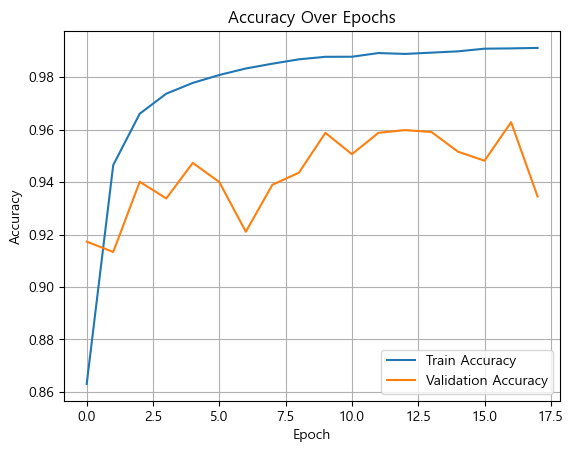

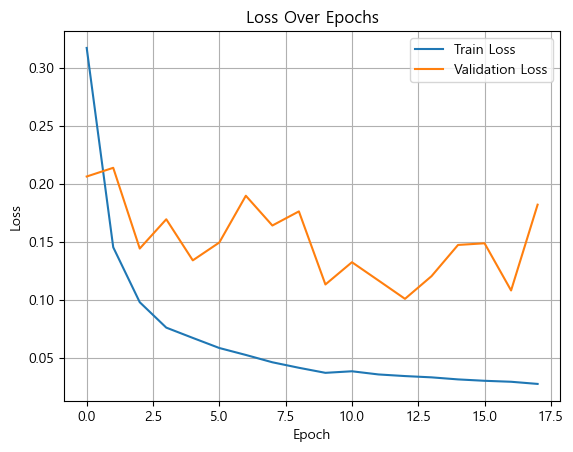

In [27]:
# import matplotlib.pyplot as plt

# 정확도
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 손실
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

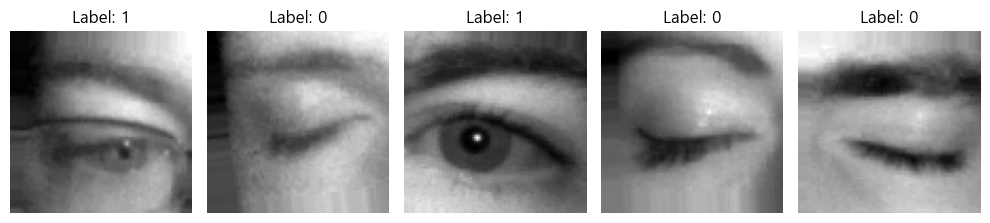

In [29]:
imgs, labels = next(train_generator)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
model.save("./../../src/models/02_Basic_Model/drowsiness_model.keras")

Found 9600 images belonging to 2 classes.


C:\Users\dear1\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


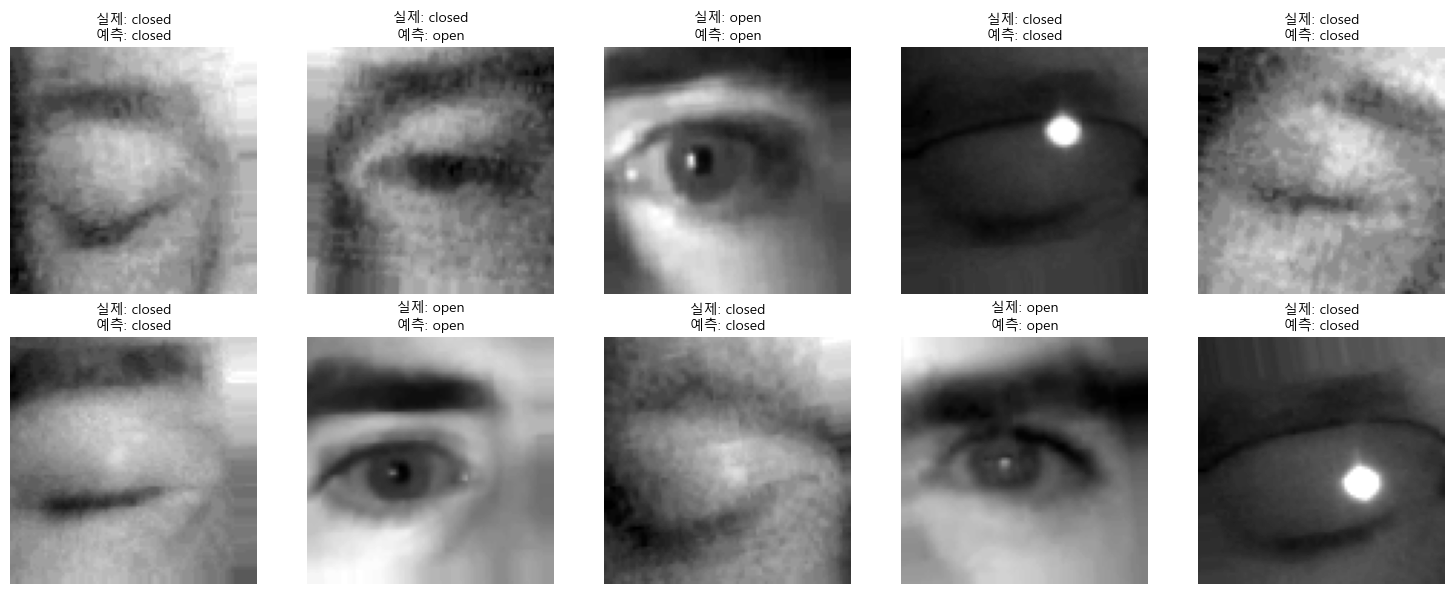

In [33]:
# import matplotlib.pyplot as plt
# import numpy as np
# import random

# 1. 검증 generator (shuffle=False)
vis_generator = datagen.flow_from_directory(
    directory=new_base,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

# 2. 전체 예측값
Y_pred = model.predict(vis_generator, verbose=0)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = vis_generator.classes
class_names = list(vis_generator.class_indices.keys())

# 3. 무작위로 인덱스 10개 추출
total_samples = len(y_true)
random_indices = random.sample(range(total_samples), 10)

# 4. 이미지 접근 및 시각화
plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    batch_index = idx // BATCH_SIZE
    offset = idx % BATCH_SIZE

    vis_generator.reset()
    for _ in range(batch_index + 1):
        images, _ = next(vis_generator)

    img = images[offset].squeeze()
    true_label = class_names[int(y_true[idx])]
    pred_label = class_names[int(y_pred[idx])]

    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"실제: {true_label}\n예측: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Keras Tuner

In [35]:
# import os
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from kerastuner.tuners import RandomSearch
# from kerastuner.engine.hypermodel import HyperModel

# 이미지 설정
IMG_SIZE = 86
BATCH_SIZE = 16
SEED = 42
new_base = './../../data/processed/02_kaggle_dataset/train'

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=new_base,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator = datagen.flow_from_directory(
    directory=new_base,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

# HyperModel 클래스 정의
class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # Conv Block 1
        model.add(Conv2D(hp.Int('conv_1_filter', 32, 64, step=16),
                         kernel_size=(3,3),
                         activation='relu',
                         input_shape=(IMG_SIZE, IMG_SIZE, 1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))

        # Conv Block 2
        model.add(Conv2D(hp.Int('conv_2_filter', 64, 128, step=32),
                         kernel_size=(3,3),
                         activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))

        # FC Layer
        model.add(Flatten())
        model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
        model.add(Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

# Tuner 정의
tuner = RandomSearch(
    CNNHyperModel(),
    objective='val_accuracy',
    max_trials=10,  # 시도할 조합 수
    executions_per_trial=1,
    directory='tuner_results',
    project_name='eye_status_cnn'
)

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# 하이퍼파라미터 탐색 시작
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

# 최적 모델 확인
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 10 Complete [00h 24m 29s]
val_accuracy: 0.948437511920929

Best val_accuracy So Far: 0.9541666507720947
Total elapsed time: 3d 12h 12m 50s


C:\Users\dear1\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 84, 84, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 84, 84, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 96)          │          27,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40, 40, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,457,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,486,305 (9.48 MB)

 Trainable params: 2,486,049 (9.48 MB)

 Non-trainable params: 256 (1.00 KB)

In [38]:
loss, acc = best_model.evaluate(val_generator)
print(f"Best Model Accuracy on Validation Set: {acc:.4f}")

600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9758 - loss: 0.0740
Best Model Accuracy on Validation Set: 0.9574


In [40]:
# 최적 trial 가져오기
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# 각 하이퍼파라미터 값 출력
print("Best Hyperparameters:")
print(f"conv_1_filter: {best_hp.get('conv_1_filter')}")
print(f"conv_2_filter: {best_hp.get('conv_2_filter')}")
print(f"dense_units: {best_hp.get('dense_units')}")
print(f"dropout: {best_hp.get('dropout')}")
print(f"learning_rate: {best_hp.get('lr')}")

Best Hyperparameters:
conv_1_filter: 32
conv_2_filter: 96
dense_units: 64
dropout: 0.3
learning_rate: 0.00027600388247395235


In [42]:
tuner.results_summary()

Results summary
Results in tuner_results\eye_status_cnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 96
dense_units: 64
dropout: 0.3
lr: 0.00027600388247395235
Score: 0.9541666507720947

Trial 04 summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 128
dense_units: 64
dropout: 0.4
lr: 0.0008047741725190018
Score: 0.9539583325386047

Trial 00 summary
Hyperparameters:
conv_1_filter: 64
conv_2_filter: 128
dense_units: 128
dropout: 0.4
lr: 0.00040663855536752954
Score: 0.95333331823349

Trial 02 summary
Hyperparameters:
conv_1_filter: 64
conv_2_filter: 96
dense_units: 64
dropout: 0.3
lr: 0.005546664306302368
Score: 0.948437511920929

Trial 09 summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 96
dense_units: 128
dropout: 0.5
lr: 0.0014544812407025515
Score: 0.948437511920929

Trial 03 summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 128
dense_units: 64
dropout: 0.3
lr: 0.00024

In [44]:
best_model.save("best_model.keras")